In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prediction_window

In [2]:
import pandas as pd
import numpy as np
from load_data import load_chord_data_sentences, load_key_data, all_composers, load_train_test_df
from gensim.models import Word2Vec
from lstm_window import LSTMOneHot, df_string_emb_window 

**Load the data and split it between test and train composers**

In [3]:
dict_df = {} #we define this for the entropy part : save the dictionnary containing accuracies and entropies

In [4]:
#definition of the test composers (we can add several)
test_composers = ['Gesualdo']

#call the split_train_test function, to create dataframes for training, and dataframes for testing composers
df_train, df_test, composers_without_test = load_train_test_df(all_composers, test_composers, key_mode='MINOR')

#Let's see what the df_train dataframe looks like :
df_train.head(2)

,key_mode,sentence
8,MINOR,"[I:MIN, VI:MAJ, I:MIN, II:DIM, I:MIN, V:MAJ, I..."
10,MINOR,"[V:MAJ, I:MIN, V:MIN, IV:MIN, V:MAJ, I:MIN, VI..."


**Define the word2vec model**

In [5]:
min_count = 50 # Ignore words with a lower frequency frequency than this
size = 5 # Size of the embedding space
window = 2 # Neighborhood of the focus word to study for wordd2vec 
sg = 1 # 0 for CBOW, 1 for skip-gram

#we call load_chord_data_sentences to have the list of list of chords for the training composers, as input to the W2Vec model
data_without_test = load_chord_data_sentences(composers_without_test, key_mode='MINOR')

#word2vec model
word2vec_model = Word2Vec(data_without_test, min_count=min_count, size=size, window=window, sg=sg, iter = 500)

**Create dataframes for current chord and context chords**

In this section, we create the dataframes containing the input and the ouput of the model. The input is the chords that appear within a `window_size` of the current chord, and the label is the current chord. We need the input and the label in the form of embedding coordinates for the model, but also in form of strings, for the evaluation of the model. We do this for both training and testing composers.

In [6]:
window_size = 2 #window to look for to define the context

#call the df_string_emb_window funtion 
df_embedding_train, df_string_train = df_string_emb_window(word2vec_model, dataframe = df_train, window_size = window_size)
df_embedding_test, df_string_test = df_string_emb_window(word2vec_model, dataframe = df_test, window_size =window_size)

#Let's see what it looks like :
df_string_train.head(10)

,X,Y
0,"[I:MIN, VI:MAJ, II:DIM, I:MIN]",I:MIN
1,"[VI:MAJ, I:MIN, I:MIN, V:MAJ]",II:DIM
2,"[I:MIN, II:DIM, V:MAJ, I:MIN]",I:MIN
3,"[II:DIM, I:MIN, I:MIN, VI:MAJ]",V:MAJ
4,"[I:MIN, V:MAJ, VI:MAJ, I:MIN]",I:MIN
5,"[V:MAJ, I:MIN, I:MIN, II:DIM]",VI:MAJ
6,"[I:MIN, VI:MAJ, II:DIM, I:MIN]",I:MIN
7,"[VI:MAJ, I:MIN, I:MIN, V:MAJ]",II:DIM
8,"[I:MIN, II:DIM, V:MAJ, I:MIN]",I:MIN
9,"[II:DIM, I:MIN, I:MIN, VI:MAJ]",V:MAJ


We see that it takes well the context of the chord : in the second line, we can find elements of the first line, which makes sense.

**Load the vocabulary**

We have at our disposal the vocabulary used by composers : it contains all of the different chords used in the data, even if it was used just one time by one specific composer.

**Note :** Here we load just the MAJOR chords vocabulary, but when we study the MINOR chords, we must load the minor chords.

In [7]:
major_file = 'data/chord_vocab_major.txt'
minor_file = 'data/chord_vocab_minor.txt'

vocab = pd.read_csv(major_file, header = None)
vocab.head(2)

,0
0,##I:DIM
1,##I:MAJ


**Call the LSTM structure**

In this section, we define the model.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
#create the model :
hidden_dim = 15
output_size = vocab.shape[0]

#we use the window technique (input = context of the chord), we specify it by improving the input shape of the model
lstm_window = LSTMOneHot(2 * window_size * size, hidden_dim, output_size)

#define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_window.parameters(), lr=0.001)

**Train the model**

To train the model, we call the subfunction `learn` to the class we defined in the `lstm_one_hot.py` file. We use 2 epochs.

In [10]:
num_epochs = 2 #number of epochs

#training process
lstm_window.learn(df_embedding_train, df_string_train, loss_function, optimizer, num_epochs, vocab)

Epoch : 1/2, Iteration : 5000/42808 , Loss : 0.010929560398031026
Epoch : 1/2, Iteration : 10000/42808 , Loss : 0.010904078631475567
Epoch : 1/2, Iteration : 15000/42808 , Loss : 0.010646311169792899
Epoch : 1/2, Iteration : 20000/42808 , Loss : 0.010507121120928787
Epoch : 1/2, Iteration : 25000/42808 , Loss : 0.008966397232192684
Epoch : 1/2, Iteration : 30000/42808 , Loss : 0.007760058456852858
Epoch : 1/2, Iteration : 35000/42808 , Loss : 0.00867309238690068
Epoch : 1/2, Iteration : 40000/42808 , Loss : 0.00920959802007419
Epoch : 2/2, Iteration : 5000/42808 , Loss : 0.009622222574494663
Epoch : 2/2, Iteration : 10000/42808 , Loss : 0.01044931976715743
Epoch : 2/2, Iteration : 15000/42808 , Loss : 0.010071487607280142
Epoch : 2/2, Iteration : 20000/42808 , Loss : 0.009952546776091913
Epoch : 2/2, Iteration : 25000/42808 , Loss : 0.008188999939497262
Epoch : 2/2, Iteration : 30000/42808 , Loss : 0.006819206209055847
Epoch : 2/2, Iteration : 35000/42808 , Loss : 0.00815543194158272
E

**Test the model on testing set**

We call the subfunction `testing_one_hot`. This function returns the dictionnary of accuracies per chord, which we need for the entropy study.

In [11]:
dict_accuracy = lstm_window.test(df_string_test, df_embedding_test, word2vec_model, vocab)


Global Accuracy : 22.73%
Mean of similarities : 0.6479450464248657
Number of I:MIN : 22, Prediction accuracy : 31.82%
Number of VII:MAJ : 14, Prediction accuracy : 35.71%
Number of III:MAJ : 13, Prediction accuracy : 0.00%
Number of VI:MAJ : 12, Prediction accuracy : 8.33%
Number of V:MAJ : 12, Prediction accuracy : 75.00%
Number of V:MIN : 12, Prediction accuracy : 8.33%
Number of IV:MIN : 9, Prediction accuracy : 44.44%
Number of I:MAJ : 8, Prediction accuracy : 25.00%
Number of VII:MIN : 5, Prediction accuracy : 0.00%
Number of IV:MAJ : 4, Prediction accuracy : 0.00%
Number of bII:MAJ : 4, Prediction accuracy : 0.00%
Number of II:MIN : 3, Prediction accuracy : 0.00%
Number of #VI:MIN : 2, Prediction accuracy : 0.00%
Number of #VII:DIM : 2, Prediction accuracy : 0.00%
Number of #III:DIM : 2, Prediction accuracy : 0.00%
Number of III:MIN : 2, Prediction accuracy : 0.00%
Number of II:DIM : 1, Prediction accuracy : 100.00%
Number of #III:MIN : 1, Prediction accuracy : 0.00%
Number of #

**Entropy**

An other idea is to study the entropy. Entropy in our case represents the uncertainty of the use of a chord. The idea is, given a chord (say it's I:MAJ), the proportion of chords that appear after (after a I:MAJ, there is V:MAJ in 30% of cases, IV:MAJ in xx% of cases,... . We can do the same for chords that appear before the focus chord (In 50% of cases, V:MAJ is previous to I:MAJ,...)

Here is the formula of the entropy :
>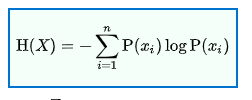

In the following we call functions that computes the entropy and plot the entropy vs accuracy per chord for the test composer

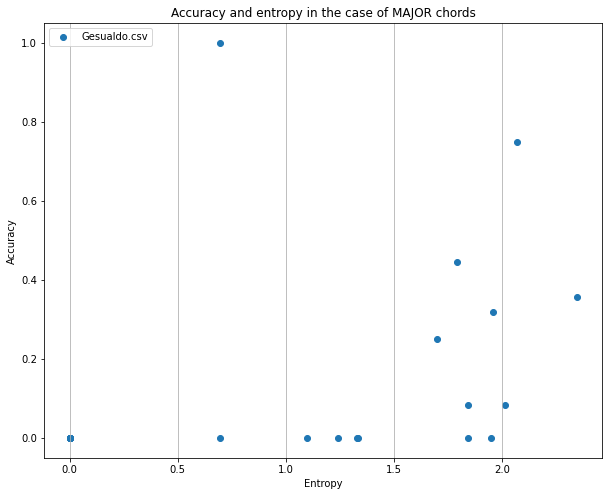

In [12]:
from entropy_study import vizualize

dict_df = vizualize(dict_accuracy, df_test, word2vec_model, test_composers, dict_df)

The expected result is that more the entropy is high, more the use of this chord appears in different context, and thus more this chord has a low accuracy, but it's not the case here. We don't seem to have any relationships, we already plotted this graph for more composers (see below) and we still don't find relations.

>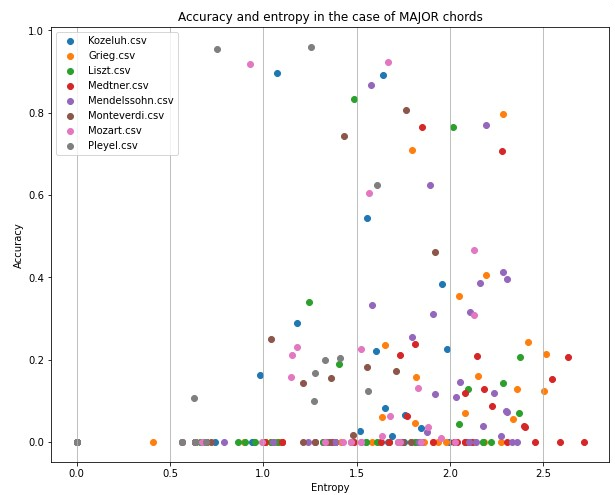